In [1]:
import numpy as np
%matplotlib inline
import healpy as hp

/Users/yoachim/lsst/DarwinX86/anaconda/2.2.0/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def _raDec2Hpid(nside, ra, dec):
    """
    Assign ra,dec points to the correct healpixel.

    Parameters
    ----------
    nside : int
        Must be a value of 2^N.
    ra : np.array
        RA values to assign to healpixels. Radians.
    dec : np.array
        Dec values to assign to healpixels. Radians.

    Returns
    -------
    hpids : np.array
        Healpixel IDs for the input positions.
    """
    lat = np.pi/2. - dec
    hpids = hp.ang2pix(nside, lat, ra)
    return hpids



In [3]:
def _healbin(ra, dec, values, nside=128, reduceFunc=np.mean, dtype=float):
    """
    Take arrays of ra's, dec's, and value and bin into healpixels. Like numpy.hexbin but for
    bins on a sphere.

    Parameters
    ----------
    ra : np.array
        RA positions of the data points. Radians.
    dec : np.array
        Dec positions of the data points. Radians
    values : np.array
        The values at each ra,dec position.
    nside : int
        Healpixel nside resolution. Must be a value of 2^N.
    reduceFunc : function (numpy.mean)
        A function that will return a single value given a subset of `values`.
    dtype : dtype ('float')
        Data type of the resulting mask

    Returns
    -------
    mapVals : np.array
        A numpy array that is a valid Healpixel map.
    """

    hpids = _raDec2Hpid(nside, ra, dec)

    order = np.argsort(hpids)
    hpids = hpids[order]
    values = values[order]
    pixids = np.unique(hpids)

    left = np.searchsorted(hpids, pixids)
    right = np.searchsorted(hpids, pixids, side='right')

    mapVals = np.zeros(hp.nside2npix(nside), dtype=dtype)+hp.UNSEEN

    # Wow, I thought histogram would be faster than the loop, but this has been faster!
    for i, idx in enumerate(pixids):
        mapVals[idx] = reduceFunc(values[left[i]:right[i]])

    # Change any NaNs to healpy mask value
    mapVals[np.isnan(mapVals)] = hp.UNSEEN

    return mapVals


In [4]:
# generate some fake stars. Not uniformly distributed on sphere.
nstars = 10000
ra = np.random.rand(nstars)*360
dec = np.random.rand(nstars)*180.-90
mags = np.random.rand(nstars)*20

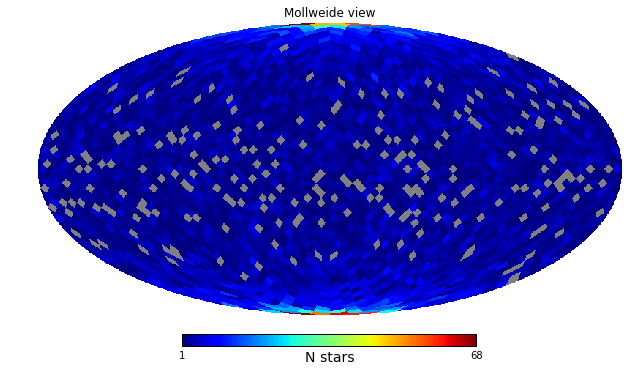

In [5]:
# Count the number of stars
starmap = _healbin(np.radians(ra),np.radians(dec),ra,nside=16, reduceFunc=np.size)
hp.mollview(starmap, unit='N stars')

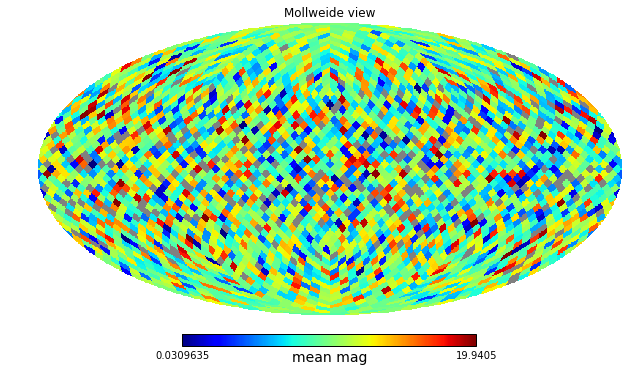

In [6]:
# find the average mag in each bin
starmap = _healbin(np.radians(ra),np.radians(dec),mags, nside=16, reduceFunc=np.mean)
hp.mollview(starmap, unit='mean mag')

In [7]:
help(_healbin)

Help on function _healbin in module __main__:

_healbin(ra, dec, values, nside=128, reduceFunc=<function mean>, dtype=<type 'float'>)
    Take arrays of ra's, dec's, and value and bin into healpixels. Like numpy.hexbin but for
    bins on a sphere.
    
    Parameters
    ----------
    ra : np.array
        RA positions of the data points. Radians.
    dec : np.array
        Dec positions of the data points. Radians
    values : np.array
        The values at each ra,dec position.
    nside : int
        Healpixel nside resolution. Must be a value of 2^N.
    reduceFunc : function (numpy.mean)
        A function that will return a single value given a subset of `values`.
    dtype : dtype ('float')
        Data type of the resulting mask
    
    Returns
    -------
    mapVals : np.array
        A numpy array that is a valid Healpixel map.

